# Validate Phanotate using the metagenomes in the SRA

This Jupyter Notebook accompanies the GitHub repository for phanotate, and demonstrates how to parse the `counts_type.tsv` file and perform the statistical analysis.

Note that this notebook does not demonstrate how to actually create the `counts_type.tsv` file, that is covered in the GitHub repository READMEs.

For more information about this please contact Rob Edwards or Kate McNair.

`Copyright 2018. Robert Edwards and Kate McNair. This is licensed under the same license as the GitHub repository in which it resides.`


In [1]:
import os
import sys

from math import log,e,sqrt

%matplotlib inline
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison

## Read the data.
Read the tab separated file into a [pandas data frame](https://pandas.pydata.org/). Note that we set the column headers and the data types, too, as we're reading the data.

In this case, we have a compressed file, and we read it without separately decompressing it.

The head() command shows us the first few lines so we can grok the data.

In [2]:
df = pd.read_csv('counts_type.tsv.gz', compression='gzip', sep='\t', header=None, names=['source', 'peg', 'count'], dtype={'source' : str, 'peg' : str, 'count': int})
df.head()

,source,peg,count
0,ANY,NC_000867.77,32
1,ANY,NC_000867.850,8
2,ANY,NC_000867.1581,0
3,ANY,NC_000867.1820,0
4,ANY,NC_000867.3717,5285


## Normalize the data.

Normalize the data using the natural log of the count.

In [3]:
df['logcount']=df.apply(lambda x: log(x['count'] + 1), axis=1)

## Show counts

These are the counts of all the data, so we can see how many entries we have.

In [4]:
for t in ["ANY", "NONE", "PHAN"]:
    print("{}: {}".format(t, df[df['source'] == t]['source'].count()))

ANY: 223386
NONE: 1122336
PHAN: 15755


## Plot the data.

Make a violin plot of the data, scaled by width. Here we are plotting `source` against `log of the count`.

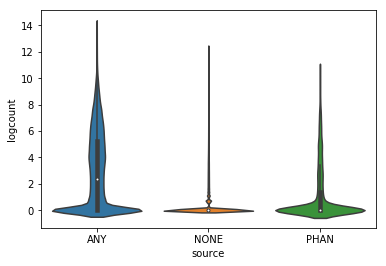

In [5]:
sb.violinplot(x='source', y='logcount', data=df, orient='v', scale='width')

## Remove the zero's

This data has lots of zero's so we filter them out of the data frame. These are predicted proteins that are never seen in any of the metagenomes.

We make a new frame (dataframe no zero's) with the data, and repeat the counts and plot from above.

In [6]:
dfnz=df[df['count'] > 0]

Count the data, showing the original counts, and how many were removed.

In [7]:
for t in ["ANY", "NONE", "PHAN"]:
    z = df[df['source'] == t]['source'].count() - dfnz[dfnz['source'] == t]['source'].count()
    zp = 100.0 * (z/df[df['source'] == t]['source'].count())
    print("{}:\ttotal: {}\tnon-zero {}".format(t, 
                df[df['source'] == t]['source'].count(),
                dfnz[dfnz['source'] == t]['source'].count()), 
                end="")
    print("\tzero entries removed: {0:d}".format(z), end="")
    print(" ({0:.2f} %)".format(zp))

ANY:	total: 223386	non-zero 149771	zero entries removed: 73615 (32.95 %)
NONE:	total: 1122336	non-zero 245572	zero entries removed: 876764 (78.12 %)
PHAN:	total: 15755	non-zero 5138	zero entries removed: 10617 (67.39 %)


### Violin plot of the data.

Create a violin plot of the data to examine the distributions.

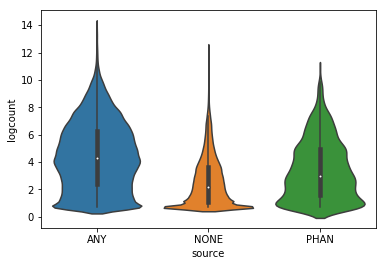

In [8]:
sb.violinplot(x='source', y='logcount', data=dfnz, orient='v', scale='width')

# Statistics

Here we compare both the data including zeros, and then on the data without the zero's.

## Including the zeros

First, a one-way anova that tests whether the means of the samples are different or not

In [9]:
F, p = stats.f_oneway(df[df["source"] == 'ANY']['logcount'], df[df["source"] == "NONE"]['logcount'], df[df["source"] == "PHAN"]['logcount'])
print("F: {0:.2f}".format(F))
print("p: {0:.2f}".format(p))

F: 184913.78
p: 0.00


This shows that the means are significantly different, but at the moment we don't know whether the means of all three samples are different, or just a couple of them. To that end, we'll run a Tukey's Honest Significant Difference test (HSD) on the data.

In the Tukey's HSD the null hypothesis is that the means are the same. In this case, we reject them if the means are different with p<=0.05 

In [10]:
rec = pairwise_tukeyhsd(df['logcount'], df['source'])
print(rec)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 ANY    NONE  -2.4147   -2.424 -2.4054  True 
 ANY    PHAN  -1.8676  -1.9007 -1.8344  True 
 NONE   PHAN   0.5472   0.5149  0.5794  True 
---------------------------------------------


In this case, we reject all the tests, therefore the means of all three groups are significantly different. Lets take a quick look at some of the data to see what we have:

Note that the standard deviations are also quite different here, we will test the difference in distributions with a Levene test shortly

In [11]:
for t in ["ANY", "PHAN", "NONE"]:
    print("Type: {} Min: {} Max: {} Mean: {} Stdev {}".format(
                 t,
                 min(df[df['source'] == t]['logcount']), 
                 max(df[df['source'] == t]['logcount']), 
                 np.mean(df[df['source'] == t]['logcount']),
                 np.std(df[df['source'] == t]['logcount']),
                ))

Type: ANY Min: 0.0 Max: 13.902029480384721 Mean: 2.9763683504319287 Stdev 2.910988238167355
Type: PHAN Min: 0.0 Max: 10.51961869044739 Mean: 1.1088080662205806 Stdev 2.017981351094044
Type: NONE Min: 0.0 Max: 12.314074669331452 Mean: 0.5616393229743065 Stdev 1.3492892280070363


The Levene test tests the null hypothesis that all input samples are from populations with equal variances (i.e. homogeneity of variance). This shows that we reject the null hypothesis that the variances are equal, and therefore there is a difference between the variance. This may suggest that we need a different transformation on our data, however a square-root transform of the data does not improve the significance (that is not shown, but replace log for sqrt!)

In [12]:
F, p = stats.levene(df[df['source'] == "ANY"]['logcount'], df[df['source'] == "NONE"]['logcount'], df[df['source'] == "PHAN"]['logcount'])
print("F: {0:.2f}".format(F))
print("p: {0:.2f}".format(p))

F: 179355.34
p: 0.00


## Ignoring the zeros

We can run the same tests without the zero data.

As we can see, statistically, this makes no difference.

In [13]:
F, p = stats.f_oneway(dfnz[dfnz["source"] == 'ANY']['logcount'], dfnz[dfnz["source"] == "NONE"]['logcount'], dfnz[dfnz["source"] == "PHAN"]['logcount'])
print("F: {0:.2f}".format(F))
print("p: {0:.2f}".format(p))

F: 37899.92
p: 0.00


In [14]:
rec = pairwise_tukeyhsd(dfnz['logcount'], dfnz['source'])
print(rec)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 ANY    NONE  -1.8724  -1.8884 -1.8565  True 
 ANY    PHAN  -1.0393  -1.1083 -0.9703  True 
 NONE   PHAN   0.8332   0.7646  0.9017  True 
---------------------------------------------


In [15]:
for t in ["ANY", "PHAN", "NONE"]:
    print("Type: {} Min: {} Max: {} Mean: {} Stdev {}".format(
                     t,
                     min(dfnz[dfnz['source'] == t]['logcount']), 
                     max(dfnz[dfnz['source'] == t]['logcount']), 
                     np.mean(dfnz[dfnz['source'] == t]['logcount']),
                     np.std(dfnz[dfnz['source'] == t]['logcount']),
                    ))

Type: ANY Min: 0.6931471805599453 Max: 13.902029480384721 Mean: 4.439304139850751 Stdev 2.4788058829114203
Type: PHAN Min: 0.6931471805599453 Max: 10.51961869044739 Mean: 3.400013834820018 Stdev 2.167229304005275
Type: NONE Min: 0.6931471805599453 Max: 12.314074669331452 Mean: 2.5668562832476467 Stdev 1.7814283102675788


In [16]:
print("Testing log counts")
F, p = stats.levene(dfnz[dfnz['source'] == "ANY"]['logcount'], dfnz[dfnz['source'] == "NONE"]['logcount'], dfnz[dfnz['source'] == "PHAN"]['logcount'])
print("\tF: {0:.2f}".format(F))
print("\tp: {0:.2f}".format(p))

Testing log counts
	F: 12705.14
	p: 0.00


## Subsampling the data

Part of the problem is we have so much data. Even ignoring the zero's we have 245,572 entries in the NONE dataset, which means pretty much anything we look at is statistically significant. The solution is to subsample some elements from teh data, and test them separately. 

Here, we subsample 1,000 elements and run the statistics 1,000 times.

Note that we are sampling with replacement &mdash; we don't normalize the samples so we have the same number of proteins from all gene callers as that would bias our results.

In [17]:
counting_matches = {'True': [0, 0, 0], 'False': [0, 0, 0]} # we count both true and false even though we only display one result
anova_sig = 0 # is the anova < 0.05
levene_sig = 0 # is the Levene test significant

# pairwise tests of levene
levene_any_none = 0
levene_any_phan = 0
levene_phan_none = 0

n = 0 # how many times we ran
for i in range(1000):
    dfsample = dfnz.sample(n=1000)
    n += 1
    
    # run the anova significance
    F, p = stats.f_oneway(dfsample[dfsample["source"] == 'ANY']['logcount'], dfsample[dfsample["source"] == "NONE"]['logcount'], dfsample[dfsample["source"] == "PHAN"]['logcount'])
    if p < 0.05:
        anova_sig += 1
    
    # run the Tukey's test
    rec = pairwise_tukeyhsd(dfsample['logcount'], dfsample['source'])
    # print(rec)
    
    # the results are always [Any -> None, Any -> Phan, None -> Phan]
    for i, t in enumerate(rec.reject):
        if t:
            counting_matches['True'][i] += 1
        else:
            counting_matches['False'][i] += 1
       
        
    # run the Levene test
    F, p = stats.levene(dfsample[dfsample['source'] == "ANY"]['logcount'], dfsample[dfsample['source'] == "NONE"]['logcount'], dfsample[dfsample['source'] == "PHAN"]['logcount'])
    if p < 0.05:
        levene_sig += 1

    # run the Levene test for pairwise samples
    F, p = stats.levene(dfsample[dfsample['source'] == "ANY"]['logcount'], dfsample[dfsample['source'] == "NONE"]['logcount'])
    if p < 0.05:
        levene_any_none += 1
        
    F, p = stats.levene(dfsample[dfsample['source'] == "ANY"]['logcount'], dfsample[dfsample['source'] == "PHAN"]['logcount'])
    if p < 0.05:
        levene_any_phan += 1
        
    F, p = stats.levene(dfsample[dfsample['source'] == "PHAN"]['logcount'], dfsample[dfsample['source'] == "NONE"]['logcount'])
    if p < 0.05:
        levene_phan_none += 1
        
        
print("Out of {} runs of the random subsample with replacement".format(n))
print("ANOVA significant (i.e. means are different): {0:.2f} %".format(anova_sig/n*100))
print("Levene significant (ie. stdev are different): {0:.2f} %".format(levene_sig/n*100))
print("Levene significant ANY-NONE (ie. stdev are different): {0:.2f} %".format(levene_any_none/n*100))
print("Levene significant ANY-PHAN (ie. stdev are different): {0:.2f} %".format(levene_any_phan/n*100))
print("Levene significant PHAN-NONE (ie. stdev are different): {0:.2f} %".format(levene_phan_none/n*100))
print("Mean of ANY  is the same as mean of NONE: {0:.2f} %".format(counting_matches['False'][0]/n*100))
print("Mean of ANY  is the same as mean of PHAN: {0:.2f} %".format(counting_matches['False'][1]/n*100))
print("Mean of NONE is the same as mean of PHAN: {0:.2f} %".format(counting_matches['False'][2]/n*100))

Out of 1000 runs of the random subsample with replacement
ANOVA significant (i.e. means are different): 100.00 %
Levene significant (ie. stdev are different): 100.00 %
Levene significant ANY-NONE (ie. stdev are different): 100.00 %
Levene significant ANY-PHAN (ie. stdev are different): 15.20 %
Levene significant PHAN-NONE (ie. stdev are different): 15.60 %
Mean of ANY  is the same as mean of NONE: 0.00 %
Mean of ANY  is the same as mean of PHAN: 71.90 %
Mean of NONE is the same as mean of PHAN: 79.10 %


This shows that ANY is *never* like NONE &mdash; in other words our basic hypothesis that if proteins are functional they are more likely to be conserved in the metagenomics datasets has been supported. We can therefore use this to test whether the proteins we predict are likely to be real or likely to be erroneous.

When I ran this sample, 79% of the time ORFs predicted to be genes were similar to the NONE set of ORFs, but 72% of the time they were similar to the ANY set of predicted proteins.

# Summary

The raw statistics suggest that all three data sets are diferrent, but the numbers are so huge that any statistical test is skewed by the large numbers. 

However, the subsampling suggests that ANY and PHAN are similar, and NONE and PHAN are similar, but that ANY and NONE are completely different from each other. I never see ANY and NONE having the same mean.

In other words, the mean of PHAN is somewhere between the mean of NONE and the mean of ANY. Therefore, the ORFs that we predict with Phanotate are often likely to have more similarity to DNA sequences in the Short Read Archive and could plausibly be real proteins.